# EDA of Chatbot Arena Dataset -- Starter Notebook

This notebook aims to help you explore the Chatbot Arena dataset, where two chatbots answer human questions, and users vote on the best response. Through this EDA, we will:
- Understand the dataset structure and contents.
- Explore the distribution of questions, responses, and chatbots.
- Identify patterns in the data to guide future modeling tasks.

## 1. Understanding the Dataset
The source dataset comes from https://huggingface.co/datasets/lmsys/chatbot_arena_conversations. The author describes the dataset as follows:

> This dataset contains 33K cleaned conversations with pairwise human preferences. It is collected from 13K unique IP addresses on the Chatbot Arena from April to June 2023. Each sample includes a question ID, two model names, their full conversation text in OpenAI API JSON format, the user vote, the anonymized user ID, the detected language tag, the OpenAI moderation API tag, the additional toxic tag, and the timestamp.

[Chatbot Arena](https://chat.lmsys.org/) is a platform where users can ask questions and two chatbots will provide answers. The user then votes on which chatbot provided the best answer. The dataset contains the questions, the answers, and the user votes.

### Main Dataset

- **Conversation Data**
You can find the processed dataset in `./chatbot-arena-conversations.jsonl.gz`. The dataset is in JSON line format and compressed using gzip. It has gone through the following preprocessing steps to make analysis easier:

    - Removed non-English conversations.
    - Removed conversations with more than one round.
    - Removed conversations classified as toxic or harmful.

The dataset you will be working with contains `25282` rows (out of `33000` total rows) and `7` columns. The columns are:

- `question_id`: A unique identifier for the question.
- `model_a`: The name of the first chatbot model.
- `model_b`: The name of the second chatbot model.
- `winner`: The name of the chatbot model that won the user vote.
- `judge`: The anonymized user ID that voted.
- `conversation_a`: The conversation between the user and `model_a`.
- `conversation_b`: The conversation between the user and `model_b`.

An example of the data is as follows:

```json
{
  "question_id": "c0fc42c6f5f14f2aa5a89f71f8553730",
  "model_a": "vicuna-13b",
  "model_b": "koala-13b",
  "winner": "model_a",
  "judge": "arena_user_973",
  "conversation_a": [
    {
      "content": "Count from 1 to 10 with step = 3",
      "role": "user"
    },
    {
      "content": "1, 4, 7, 10\n\nCounting with a step of 3 means that you will increase the number by 3 each time. So, the first number is 1, the next is 4 (1 + 3), the next is 7 (4 + 3), and so on.",
      "role": "assistant"
    }
  ],
  "conversation_b": [
    {
      "content": "Count from 1 to 10 with step = 3",
      "role": "user"
    },
    {
      "content": "1, 4, 7, 10",
      "role": "assistant"
    }
  ]
}
```

### Auxiliary Datasets

There are four auxiliary datasets that you can use to help with your analysis:

- **Embedding Data**
    - `./chatbot-arena-prompts-embeddings.npy` contains the 256-dimensional text embeddings for each of the human questions. The embeddings are generated using OpenAI’s text-embedding model. We will explain what embeddings are and how you can use them later.
    - `./chatbot-arena-model_a_response-embeddings.npy` contains the 256-dimensional text embeddings for each of the model a responses (second half of conversation a). The embeddings are generated using OpenAI’s text-embedding model. 
     - `./chatbot-arena-model_b_response-embeddings.npy` contains the 256-dimensional text embeddings for each of of the model b responses (second half of conversation b). The embeddings are generated using OpenAI’s text-embedding model.

- **Topic Modeling and Hardness Score Data**
- `./chatbot-arena-gpt3-scores.jsonl.gz` ([example row](https://gist.github.com/simon-mo/25c5d532bccc7f28b404cffdfe719e6e#file-example-aux-row-json))
 contains labels for the dataset, which you can use for later modeling tasks. It has the following fields:
  - **question_id**: The unique identifier for the question, as seen in `./chatbot-arena-conversations.jsonl.gz`.
  - **prompt**: The extracted human question. This is equivalent to the first message in `conversation_a` and `conversation_b` in `./chatbot-arena-conversations.jsonl.gz`.
  - **openai_scores_raw_choices_nested**: The response from OpenAI GPT 3.5 model. It contains:
    - The evaluated topic model
    - The reason for a hardness score (from 1 to 10)
    - The score value

  For each prompt, we have 3 responses from GPT 3.5 because it is a probabilistic model. In the real world, multiple annotators may provide different labels for ground truth data. We extracted the following fields into columns:

  - **topic_modeling_1, topic_modeling_2, topic_modeling_3**: Topic modeling for the first, second, and third response. Each topic contains two words.
  - **score_reason_1, score_reason_2, score_reason_3**: The reasons for the hardness score for the first, second, and third response.
  - **score_value_1, score_value_2, score_value_3**: The hardness score for the first, second, and third response.
 
```json
{
  "question_id": "58210e39b3fd4441a2bd4a518bb44c2d",
  "prompt": "What is the difference between OpenCL and CUDA?",
  "openai_scores_raw_choices_nested": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "{\n    \"topic_modeling\": \"Technical Comparison\",\n    \"score_reason\": \"This prompt requires the AI to accurately compare and contrast two distinct technologies, OpenCL and CUDA. It assesses the AI's factual accuracy and knowledge of these technologies, as well as its ability to articulate the differences between them.\",\n    \"score_value\": 9\n}",
        "role": "assistant",
        "function_call": null,
        "tool_calls": null
      }
    },
    {
      "finish_reason": "stop",
      "index": 1,
      "logprobs": null,
      "message": {
        "content": "{\n    \"topic_modeling\": \"Software Comparison\",\n    \"score_reason\": \"This prompt assesses the AI's factual accuracy in distinguishing between two similar but distinct software frameworks.\",\n    \"score_value\": 8\n}",
        "role": "assistant",
        "function_call": null,
        "tool_calls": null
      }
    },
    {
      "finish_reason": "stop",
      "index": 2,
      "logprobs": null,
      "message": {
        "content": "{\n    \"topic_modeling\": \"Comparison, Technology\",\n    \"score_reason\": \"This prompt requires the AI to demonstrate knowledge of two different technologies, compare their features, and explain their distinctions. This task assesses the AI's factual accuracy and proficiency in understanding complex technological concepts.\",\n    \"score_value\": 9\n}",
        "role": "assistant",
        "function_call": null,
        "tool_calls": null
      }
    }
  ],
  "topic_modeling_1": "Technical Comparison",
  "score_reason_1": "This prompt requires the AI to accurately compare and contrast two distinct technologies, OpenCL and CUDA. It assesses the AI's factual accuracy and knowledge of these technologies, as well as its ability to articulate the differences between them.",
  "score_value_1": 9,
  "topic_modeling_2": "Software Comparison",
  "score_reason_2": "This prompt assesses the AI's factual accuracy in distinguishing between two similar but distinct software frameworks.",
  "score_value_2": 8,
  "topic_modeling_3": "Comparison, Technology",
  "score_reason_3": "This prompt requires the AI to demonstrate knowledge of two different technologies, compare their features, and explain their distinctions. This task assesses the AI's factual accuracy and proficiency in understanding complex technological concepts.",
  "score_value_3": 9
}
```

## 2. Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

In [2]:
# Main Dataset

# Conversation Data -- we will use this data in the "Conversation Data" section
df = pd.read_json(
    "./data100-shared-readwrite/fa24_grad_project_data/nlp-chatbot-analysis_data/training-set/chatbot-arena-conversations.jsonl.gz",
    lines=True,
    compression="gzip"
)
df.head(5)

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?..."
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use..."


In [3]:
# Auxiliary Datasets

# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "./data100-shared-readwrite/fa24_grad_project_data/nlp-chatbot-analysis_data/training-set/chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "./data100-shared-readwrite/fa24_grad_project_data/nlp-chatbot-analysis_data/training-set/chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "./data100-shared-readwrite/fa24_grad_project_data/nlp-chatbot-analysis_data/training-set/chatbot-arena-model_b_response-embeddings.npy"
)

# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "./data100-shared-readwrite/fa24_grad_project_data/nlp-chatbot-analysis_data/training-set/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

## 3. Exploring the Data

### Converstation Data

Let's investigate the conversation data first (`chatbot-arena-conversations.jsonl.gz`). It is in JSON line format, compressed with `gzip`. You can load the data with `pd.read_json`.

Before diving into any analysis, it's important to understand the structure of the dataset. In this section, we'll check the basic details of the data, such as the number of rows, column names, data types, and any missing values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25282 entries, 0 to 25281
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     25282 non-null  object
 1   model_a         25282 non-null  object
 2   model_b         25282 non-null  object
 3   winner          25282 non-null  object
 4   judge           25282 non-null  object
 5   conversation_a  25282 non-null  object
 6   conversation_b  25282 non-null  object
dtypes: object(7)
memory usage: 1.4+ MB


In [5]:
df.isnull().sum()

question_id       0
model_a           0
model_b           0
winner            0
judge             0
conversation_a    0
conversation_b    0
dtype: int64

As an example to guide you through the exploratory process, let’s investigate the length distribution of the prompt. This helps answer questions like (this is related to the ``Distribution of the prompt and response length'' requirement of the EDA assingment).
: 

- Do the arena users ask long or short questions?
- What is the average length of prompts that users give to the chatbots?

By analyzing the length of the prompts, you can start forming hypotheses about how the length might affect model performance or user votes. This example will guide you in asking similar questions about other aspects of the dataset.

In [6]:
df["prompt"] = df["conversation_a"].str[0].str["content"]
df["prompt"].head(1)

0    What is the difference between OpenCL and CUDA?
Name: prompt, dtype: object

In [7]:
df["prompt_length"] = df["prompt"].str.len()
df["prompt_length"].describe()

count    25282.00000
mean       196.74646
std        369.05595
min         16.00000
25%         42.00000
50%         72.00000
75%        156.00000
max       2560.00000
Name: prompt_length, dtype: float64

Looks like the mean length of the prompt is about **200 characters, while the median is 72 characters**. This suggests that the distribution is **right-skewed!** Let's visualize this.

<Axes: xlabel='prompt_length', ylabel='Count'>

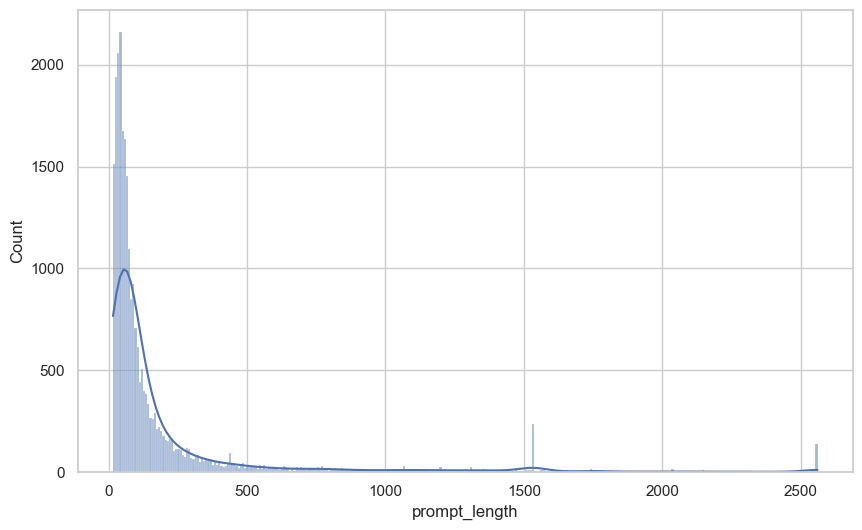

In [8]:
# Plot the distribution of the length of the prompt
plt.figure(figsize=(10, 6))
sns.histplot(df["prompt_length"], kde=True)

Now, can you apply the same thought process to visualize the distribution of the response length? 

Applying the same logic you used to make the `prompt` column, you should also make the columns `model_a_response` and `model_b_response` by extracting the **second half** of the content from `conversation_a` and `conversation_b` respectively in order to look into specific content of the model responses.

In [9]:
# Function to extract the assistant's response from a conversation
def extract_assistant_response(conversation):
    """
    Extracts the assistant's response from a conversation list.
    
    Parameters:
    - conversation (list): A list of dictionaries representing the conversation turns.
    
    Returns:
    - str: The content of the assistant's response. Returns an empty string if not found.
    """
    if isinstance(conversation, list):
        for turn in conversation:
            if turn.get("role") == "assistant":
                return turn.get("content", "")
    return ""

# Apply the function to extract responses for both models
df["model_a_response"] = df["conversation_a"].apply(extract_assistant_response)
df["model_b_response"] = df["conversation_b"].apply(extract_assistant_response)

# Display the first few rows to verify extraction
print(df[["conversation_a", "model_a_response", "conversation_b", "model_b_response"]].head())


                                      conversation_a  \
0  [{'content': 'What is the difference between O...   
1  [{'content': 'Why did my parent not invite me ...   
2  [{'content': 'Fuji vs. Nikon, which is better?...   
3  [{'content': 'How to build an arena for chatbo...   
4  [{'content': 'When is it today?', 'role': 'use...   

                                    model_a_response  \
0  OpenCL and CUDA are two different programming ...   
1  It is possible that your parent did not invite...   
2  Both Fuji and Nikon are popular camera brands ...   
3  Building an arena for chatbots can be done by ...   
4  I'm sorry, I cannot determine the current date...   

                                      conversation_b  \
0  [{'content': 'What is the difference between O...   
1  [{'content': 'Why did my parent not invite me ...   
2  [{'content': 'Fuji vs. Nikon, which is better?...   
3  [{'content': 'How to build an arena for chatbo...   
4  [{'content': 'When is it today?', 'role': '

In [10]:
# Verify if any responses are missing after extraction
missing_a_responses = df["model_a_response"].isnull().sum()
missing_b_responses = df["model_b_response"].isnull().sum()

print(f"Missing Model A Responses: {missing_a_responses}")
print(f"Missing Model B Responses: {missing_b_responses}")


Missing Model A Responses: 0
Missing Model B Responses: 0


In [11]:
# Calculate the length of each response in characters
df["model_a_response_length"] = df["model_a_response"].str.len()
df["model_b_response_length"] = df["model_b_response"].str.len()

# Display descriptive statistics for response lengths
print("Model A Response Length Statistics:")
print(df["model_a_response_length"].describe())
print("\nModel B Response Length Statistics:")
print(df["model_b_response_length"].describe())


Model A Response Length Statistics:
count    25282.000000
mean       772.708409
std        655.798032
min          1.000000
25%        232.000000
50%        591.000000
75%       1215.750000
max       9857.000000
Name: model_a_response_length, dtype: float64

Model B Response Length Statistics:
count    25282.000000
mean       773.163911
std        658.803491
min          1.000000
25%        232.000000
50%        582.000000
75%       1214.750000
max       7135.000000
Name: model_b_response_length, dtype: float64


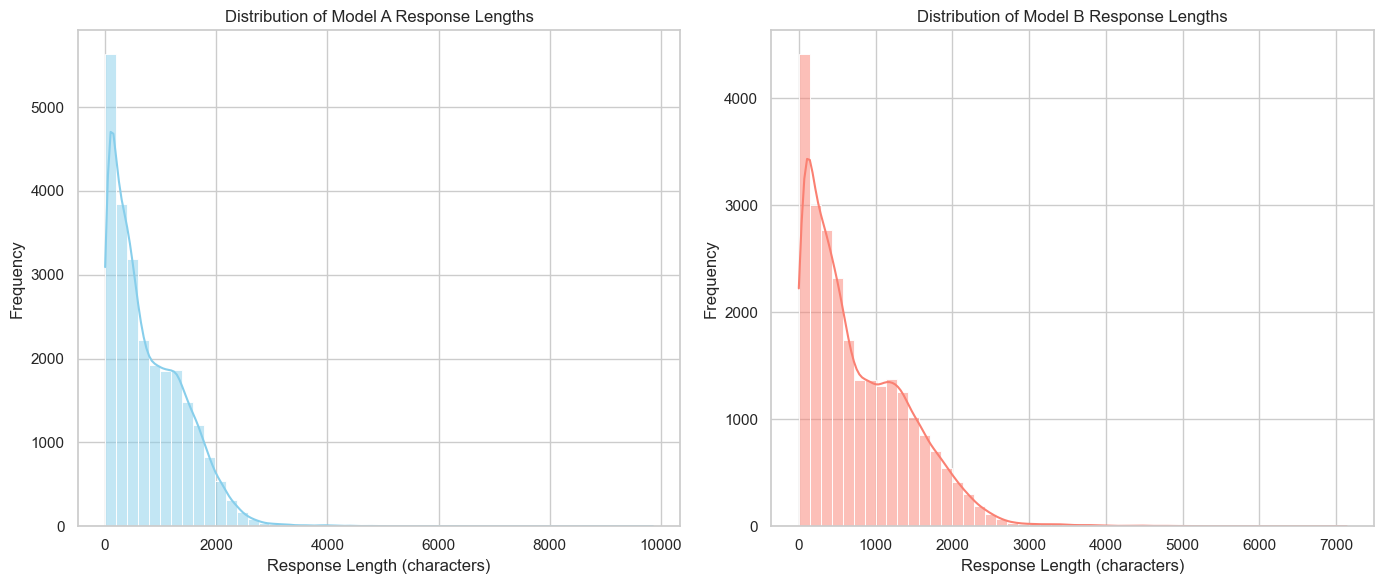

In [12]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Histogram and KDE for Model A
plt.subplot(1, 2, 1)
sns.histplot(df["model_a_response_length"], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Model A Response Lengths")
plt.xlabel("Response Length (characters)")
plt.ylabel("Frequency")

# Histogram and KDE for Model B
plt.subplot(1, 2, 2)
sns.histplot(df["model_b_response_length"], bins=50, kde=True, color='salmon')
plt.title("Distribution of Model B Response Lengths")
plt.xlabel("Response Length (characters)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


C:\Users\daisy\AppData\Local\Temp\ipykernel_7356\3548644306.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["model_a_response_length"], shade=True, label='Model A', color='skyblue')
C:\Users\daisy\AppData\Local\Temp\ipykernel_7356\3548644306.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["model_b_response_length"], shade=True, label='Model B', color='salmon')


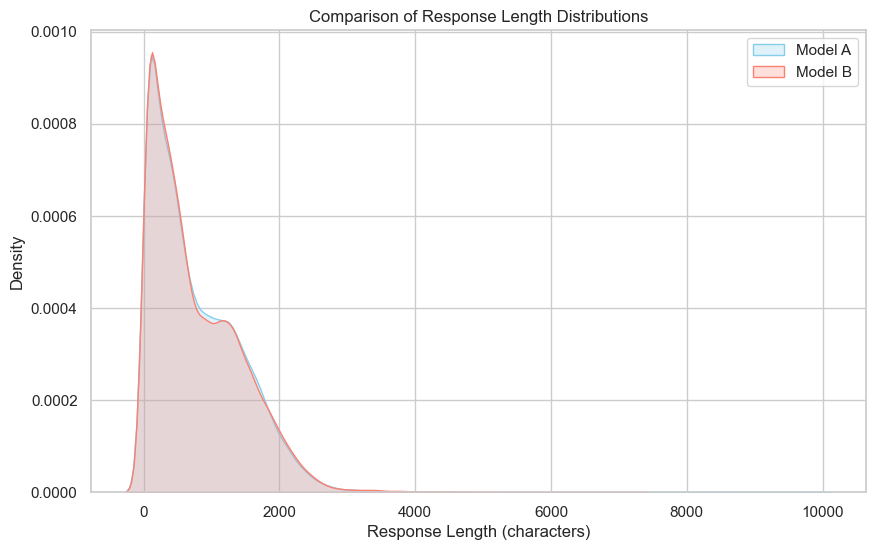

In [13]:
# Overlayed KDE plots for both models
plt.figure(figsize=(10, 6))
sns.kdeplot(df["model_a_response_length"], shade=True, label='Model A', color='skyblue')
sns.kdeplot(df["model_b_response_length"], shade=True, label='Model B', color='salmon')
plt.title("Comparison of Response Length Distributions")
plt.xlabel("Response Length (characters)")
plt.ylabel("Density")
plt.legend()
plt.show()


#### Handling Outliers in Response Lengths

In [14]:
# Define capping thresholds (e.g., 95th percentile)
cap_a = df["model_a_response_length"].quantile(0.99)
cap_b = df["model_b_response_length"].quantile(0.99)

# Apply capping
df["model_a_response_length_capped"] = df["model_a_response_length"].clip(upper=cap_a)
df["model_b_response_length_capped"] = df["model_b_response_length"].clip(upper=cap_b)

# Verify capping
print("Model A Response Length Capped at 99th Percentile:")
print(df["model_a_response_length_capped"].describe())

print("\nModel B Response Length Capped at 99th Percentile:")
print(df["model_b_response_length_capped"].describe())


Model A Response Length Capped at 99th Percentile:
count    25282.000000
mean       766.487026
std        629.613944
min          1.000000
25%        232.000000
50%        591.000000
75%       1215.750000
max       2531.000000
Name: model_a_response_length_capped, dtype: float64

Model B Response Length Capped at 99th Percentile:
count    25282.000000
mean       766.966628
std        635.472378
min          1.000000
25%        232.000000
50%        582.000000
75%       1214.750000
max       2555.760000
Name: model_b_response_length_capped, dtype: float64


In [15]:
# Define removal thresholds (e.g., 99th percentile)
threshold_a = df["model_a_response_length"].quantile(0.99)
threshold_b = df["model_b_response_length"].quantile(0.99)

# Filter out outliers
df_filtered = df[
    (df["model_a_response_length"] <= threshold_a) &
    (df["model_b_response_length"] <= threshold_b)
]

print(f"Original dataset size: {df.shape[0]}")
print(f"Filtered dataset size: {df_filtered.shape[0]}")


Original dataset size: 25282
Filtered dataset size: 24804


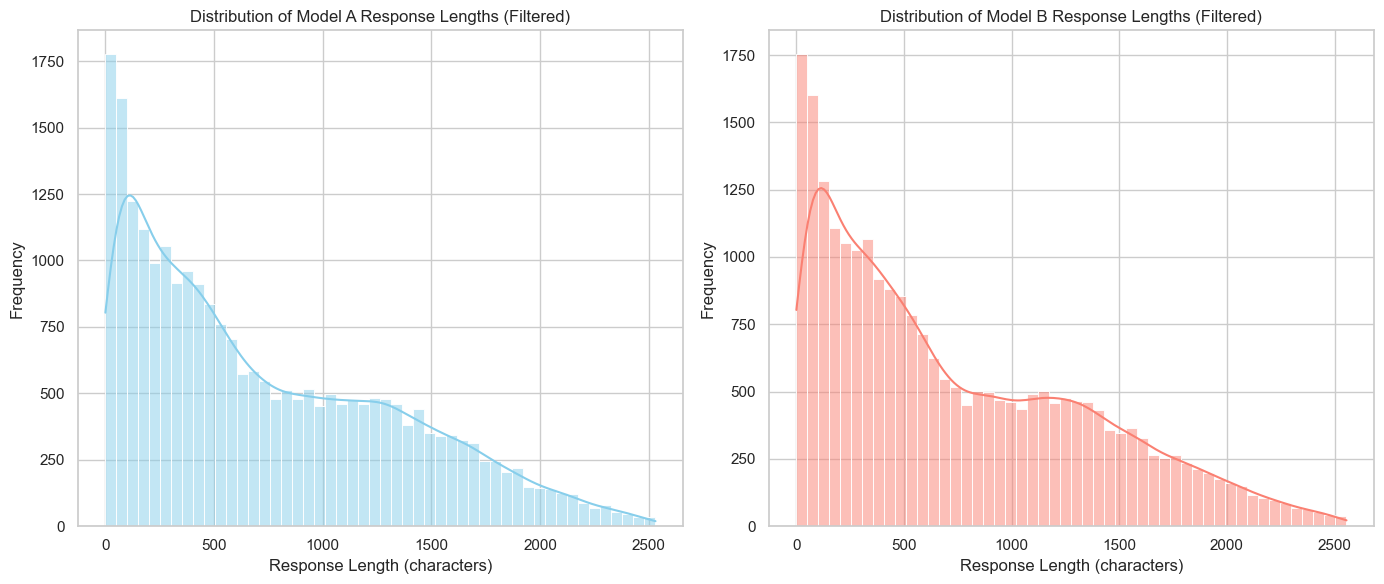

In [16]:
# Set Seaborn theme for consistency
sns.set_theme(style="whitegrid")

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Histogram and KDE for Model A
plt.subplot(1, 2, 1)
sns.histplot(df_filtered["model_a_response_length"], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Model A Response Lengths (Filtered)")
plt.xlabel("Response Length (characters)")
plt.ylabel("Frequency")

# Histogram and KDE for Model B
plt.subplot(1, 2, 2)
sns.histplot(df_filtered["model_b_response_length"], bins=50, kde=True, color='salmon')
plt.title("Distribution of Model B Response Lengths (Filtered)")
plt.xlabel("Response Length (characters)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


#### Handling Outliers in prompt_length

In [17]:
# Define capping threshold at the 99th percentile
cap_threshold = df_filtered["prompt_length"].quantile(0.99)
print(f"Capping Threshold (99th Percentile): {cap_threshold}")

# Apply capping
df_filtered["prompt_length_capped"] = df_filtered["prompt_length"].clip(upper=cap_threshold)

# Verify the capping
print("Descriptive Statistics After Capping:")
print(df_filtered["prompt_length_capped"].describe())

# Confirm no values exceed the cap
print(f"Maximum Prompt Length After Capping: {df_filtered['prompt_length_capped'].max()}")


Capping Threshold (99th Percentile): 1982.9400000000023
Descriptive Statistics After Capping:
count    24804.000000
mean       189.565395
std        340.127300
min         16.000000
25%         42.000000
50%         71.000000
75%        154.000000
max       1982.940000
Name: prompt_length_capped, dtype: float64
Maximum Prompt Length After Capping: 1982.9400000000023


C:\Users\daisy\AppData\Local\Temp\ipykernel_7356\2178182483.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["prompt_length_capped"] = df_filtered["prompt_length"].clip(upper=cap_threshold)


In [18]:
# Optionally, drop the original 'prompt_length' and rename the capped version
df_filtered = df_filtered.drop(columns=["prompt_length"])
df_filtered = df_filtered.rename(columns={"prompt_length_capped": "prompt_length"})

# Confirm the changes
print(df_filtered["prompt_length"].describe())


count    24804.000000
mean       189.565395
std        340.127300
min         16.000000
25%         42.000000
50%         71.000000
75%        154.000000
max       1982.940000
Name: prompt_length, dtype: float64


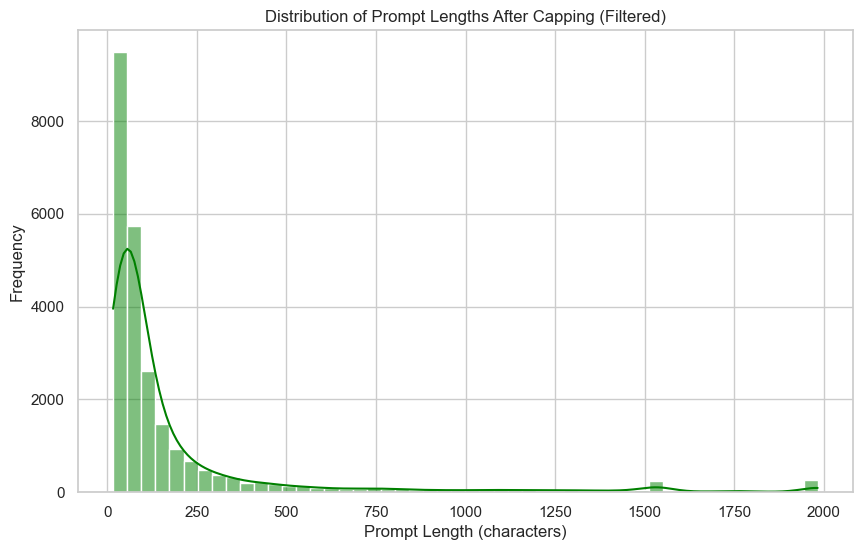

In [19]:
# Histogram and KDE for Capped Prompt Length
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered["prompt_length"], bins=50, kde=True, color='green')
plt.title("Distribution of Prompt Lengths After Capping (Filtered)")
plt.xlabel("Prompt Length (characters)")
plt.ylabel("Frequency")
plt.show()


### Embedding Data

Text embedding models transform natural language text into numerical vectors. The vectors are generated in such a way that semantically similar text are close to each other in the vector space. In the real world, these embeddings to find similar questions or to cluster the questions.

Concretely, the auxiliary dataset,`./chatbot-arena-prompts-embeddings.npy`, `./chatbot-arena-model_a_response-embeddings.npy`, and `./chatbot-arena-model_b_response-embeddings.npy`, contains 256-dimensional text embeddings for each of the human questions, model a responses and model b responses respectively. 

In this section, we will walk you through an example of computing the similarity between prompts using the precomputed embeddings (`./chatbot-arena-prompts-embeddings.npy`). The goal is to find prompts that are most similar to a given prompt based on their embeddings.

Before we get started, let's first load and output the `propmt_embeddings` which we have loaded in the second section to see what they look like. Each embedding is a 256-dimensional vector that represents the semantic meaning of a prompt. These vectors allow us to compare prompts based on their content.

In [20]:
prompt_embeddings

array([[-0.12376316, -0.1173524 ,  0.04567662, ..., -0.02439648,
        -0.03724024, -0.04380682],
       [ 0.00602781,  0.02843601, -0.09102212, ...,  0.08506154,
        -0.05333152,  0.00185428],
       [-0.03522179, -0.10940242, -0.02224718, ..., -0.14116742,
         0.00477351,  0.00416916],
       ...,
       [ 0.02476096, -0.02741823,  0.07049022, ..., -0.05541623,
        -0.02461602,  0.06005438],
       [ 0.01620374,  0.04473886,  0.08496623, ..., -0.02189322,
        -0.05438842,  0.02849752],
       [-0.04179214,  0.00963908, -0.00338678, ...,  0.08221702,
        -0.02381286, -0.10591594]], dtype=float32)

The embeddings are a matrix where each row corresponds to a prompt from the dataset. Each row is a 256-dimensional vector that captures the semantic meaning of the prompt.

In [21]:
prompt_embeddings.shape

(25282, 256)

The embeddings array has a shape of `(25282, 256)`, meaning there are 25,282 embeddings (one for each prompt), and each embedding is a 256-dimensional vector.

Next, we will:
1. Take a sample of the embeddings to reduce computation time.
2. Compute the dot product between the embeddings to measure similarity.
3. Retrieve the most similar prompts to a chosen source prompt.
4. Output the top 5 similar prompts.
(This is related to the ``(Open-ended) Explore the prompt topics in the dataset (topic modeling).'' requirement of the EDA assignment)

Start by taking a sample of the embeddings and calculating the similarity between them using the dot product.

In [22]:
# Let's try to find the closest prompt to a given prompt
embeddings_sample = prompt_embeddings[:1000]

# Compute the dot product between the embeddings
dot_product = np.dot(embeddings_sample, embeddings_sample.T)
dot_product.shape

(1000, 1000)

Given the above output, the dot product matrix has a shape of (1000, 1000), meaning we have similarity scores between all pairs of prompts in our sample of 1000.

Next, let's choose a prompt and find the top 5 most similar prompts based on the computed similarity.

In [23]:
source_prompt_idx = 23
source_prompt = df.iloc[source_prompt_idx].prompt
source_prompt

'Write me a function to lazily compute a Fibonacci sequence in Clojure. '

The prompt we're using as a reference (index 23) is:

`'Write me a function to lazily compute a Fibonacci sequence in Clojure.'`

Now let's find the top 5 most similar prompts to this one.

In [24]:
top_k = 5
similar_promts_idx = np.argsort(dot_product[source_prompt_idx])[-top_k:][::-1]
similar_promts = df.iloc[similar_promts_idx].prompt
similar_promts.tolist()

['Write me a function to lazily compute a Fibonacci sequence in Clojure. ',
 "Let's write a function that sums every third number from 1 to 100.",
 'Write an efficient Fibonacci number calculator in Python. ',
 'Write a program in Ocaml to compute the square root of a number.',
 'What is a pure function?']

As you can see, these prompts are closely related to programming tasks, many of them dealing with functions and computations. This shows how embeddings can group semantically similar questions together.

You also have the embeddings for responses from models a (`./chatbot-arena-model_a_response-embeddings.npy`) and model b (`./chatbot-arena-model_b_response-embeddings.npy`) respectively to explore. (These are the embeddings from columns `model_a_response` and `model_b_response` which can be created by extracting the second half of columns `conversation_a` and `conversation_b` respectively (as explained in the previous section).

Potential follow-up questions you can explore: 
- Can you identify clusters of similar topics within the dataset?
- How do different models perform on similar prompts?
- Can you find examples where semantically similar prompts result in different outcomes?

### Topic Modeling and Hardness Score Data

Now, let's explore the second auxiliary dataset `./chatbot-arena-gpt3-scores.jsonl.gz`, which contains valuable information for later modeling tasks. 

For each prompt, there are 3 responses, as GPT-3.5 is probabilistic. This means we get multiple labels for a single prompt, similar to how real-world datasets can have multiple annotations.

Let's start by loading and inspecting the first 5 rows of this dataset to understand its structure.

**_Warning_: This data can be messy! This is intentionally not cleaned up for you to resemble real-world data. You are responsible for figuring out the irregularities and cleaning it up. The following cells demonstrate the example of messy data.**

In [25]:
topic_and_hardness.head(5)

,question_id,prompt,openai_scores_raw_choices_nested,topic_modeling_1,score_reason_1,score_value_1,topic_modeling_2,score_reason_2,score_value_2,topic_modeling_3,score_reason_3,score_value_3
0,58210e39b3fd4441a2bd4a518bb44c2d,What is the difference between OpenCL and CUDA?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Technical Comparison,This prompt requires the AI to accurately comp...,9,Software Comparison,This prompt assesses the AI's factual accuracy...,8,"Comparison, Technology",This prompt requires the AI to demonstrate kno...,9
1,2564acd09e3942fd97657d05282d4389,Why did my parent not invite me to their wedding?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...","Reasoning, Emotion",This prompt requires the AI to understand huma...,9,"Emotions, Relationships",This prompt involves understanding complex hum...,8,"Reasoning, Emotional",This prompt challenges the AI to infer motives...,8
2,90bfd142157948aba01931726c888e7f,"Fuji vs. Nikon, which is better?","[{'finish_reason': 'stop', 'index': 0, 'logpro...",Camera comparison,This prompt does not require problem-solving s...,2,Comparative Analysis,This prompt assesses the AI's ability to analy...,6,Photography comparison,This prompt is subjective and does not provide...,2
3,a7c5accc53e649a3bc6b2e41d962ebc4,How to build an arena for chatbots?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Chatbot Arena,This prompt requires problem-solving skills an...,8,Chatbot Arena,This prompt requires the AI to engage in probl...,8,Chatbot Arena,This prompt requires problem-solving skills an...,8
4,adf27e819a3c494cb6e993f0c660e097,When is it today?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Time Query,This prompt is very straightforward and does n...,2,Date Inquiry,This prompt is very straightforward and does n...,2,Time-based Inquiry,This prompt is too straightforward and simply ...,2


**Understand the Structure**
How are the topic modeling and hardness scores structured across the dataset?
- Look at the columns `topic_modeling_1`, `score_reason_1`, `score_value_1`, etc.
- How consistent are the values across the rows? Do they follow a pattern? Are there any irregularities or unexpected values?

In [26]:
# List of score_reason columns
score_reason_columns = ['score_reason_1', 'score_reason_2', 'score_reason_3']

# Iterate through each score_reason column and display unique values
for col in score_reason_columns:
    print(f"\nUnique Values in '{col}':")
    print(topic_and_hardness[col].unique())
    print(f"Number of Unique Reasons in '{col}': {topic_and_hardness[col].nunique()}")



Unique Values in 'score_reason_1':
["This prompt requires the AI to accurately compare and contrast two distinct technologies, OpenCL and CUDA. It assesses the AI's factual accuracy and knowledge of these technologies, as well as its ability to articulate the differences between them."
 'This prompt requires the AI to understand human emotions and relationships, as well as think critically to generate plausible reasons.'
 'This prompt does not require problem-solving skills, creativity, or factual accuracy as it is subjective in nature and based on personal preferences rather than objective criteria.'
 ...
 'This prompt requires the AI to demonstrate problem-solving skills by explaining how to train a model for stable diffusion and select hyperparameters effectively. It also involves creativity in the explanation process. Additionally, the AI needs to adhere to real-world facts when discussing the training process and hyperparameter selection. Training the model using Gradio adds a pr

In [27]:
# List of score_value columns
score_value_columns = ['score_value_1', 'score_value_2', 'score_value_3']

# Check data types
print("\nData Types of 'score_value_X' Columns:")
print(topic_and_hardness[score_value_columns].dtypes)



Data Types of 'score_value_X' Columns:
score_value_1    object
score_value_2    object
score_value_3    object
dtype: object


In [28]:
# Function to check if entry is a list
def is_list(x):
    return isinstance(x, list)

# Check for lists in each score_value column
for col in score_value_columns:
    num_lists = topic_and_hardness[col].apply(is_list).sum()
    print(f"Number of lists in '{col}': {num_lists}")


Number of lists in 'score_value_1': 469
Number of lists in 'score_value_2': 443
Number of lists in 'score_value_3': 475


**Data Cleaning**
The following are some of the things (many) you should explore to clean your data:
- Are there any missing values?
- The data in the `openai_scores_raw_choices_nested` field appears messy. It contains a list of nested dictionaries that might need to be flattened for easier analysis. Consider these points:
    - Do you need all the nested data? Perhaps you only need the final hardness scores and topic modeling results for your analysis.
    - One way to deal with the nested openai_scores_raw_choices_nested field is to flatten it into more readable columns if you find you need the nested data.
- Sometimes, there could be repeated entries in the dataset. Make sure that each question (question_id) and its corresponding responses are unique.

Let’s begin by checking for missing values in our dataset.

In [29]:
topic_and_hardness.isnull().sum()

question_id                          0
prompt                               0
openai_scores_raw_choices_nested     0
topic_modeling_1                    26
score_reason_1                      26
score_value_1                       26
topic_modeling_2                    26
score_reason_2                      26
score_value_2                       26
topic_modeling_3                    26
score_reason_3                      26
score_value_3                       26
dtype: int64

What are some strategies for handling missing values?

In [30]:

# Define the columns to check for missing values
columns_with_missing = [
    'topic_modeling_1', 'score_reason_1', 'score_value_1',
    'topic_modeling_2', 'score_reason_2', 'score_value_2',
    'topic_modeling_3', 'score_reason_3', 'score_value_3'
]

# Drop rows where any of the specified columns have missing values
topic_and_hardness_cleaned = topic_and_hardness.dropna(subset=columns_with_missing)

# Verify the new shape
print(f"Original Size: {topic_and_hardness.shape[0]}")
print(f"After Removal: {topic_and_hardness_cleaned.shape[0]}")

Original Size: 25282
After Removal: 25256


Messy data is not only about missing values, it can also be about inconsistent formatting. Let's check for inconsistencies in the `score_value_1` column of the dataset. The `score_value_1` field should contain numerical values representing hardness scores. However, sometimes data can be messy, and we might encounter values that are not in the expected format (e.g., lists instead of single numbers).

The code below demonstrates how to identify rows where `score_value_1` is incorrectly formatted as a list:

In [31]:
topic_and_hardness_cleaned["score_value_1"][
    topic_and_hardness_cleaned["score_value_1"].apply(lambda x: isinstance(x, list))
].head()

12     [[8]]
48     [[7]]
86     [[7]]
144    [[8]]
181    [[7]]
Name: score_value_1, dtype: object

In [32]:
# Inspect unique types in 'score_value_1'
unique_types = topic_and_hardness_cleaned['score_value_1'].apply(type).unique()
print("Unique Data Types in 'score_value_1':", unique_types)


Unique Data Types in 'score_value_1': [<class 'int'> <class 'list'> <class 'float'>]


In [33]:
# Function to check if elements are lists and their nesting level
def check_nesting(x):
    if isinstance(x, list):
        if all(isinstance(item, list) for item in x):
            return "List of Lists"
        else:
            return "List"
    else:
        return "Single Value"

# Apply the function and get unique nesting types
nesting_types = topic_and_hardness_cleaned['score_value_1'].apply(check_nesting).unique()
print("Nesting Types in 'score_value_1':", nesting_types)


Nesting Types in 'score_value_1': ['Single Value' 'List of Lists']


In [34]:
def clean_score_value(x):
    """
    Cleans the 'score_value_1' entry by flattening nested lists and computing the average.
    
    Parameters:
    - x: The entry in 'score_value_1'.
    
    Returns:
    - float: The average hardness score or NaN if invalid.
    """
    if isinstance(x, list):
        # Flatten the list (handle multiple nesting levels)
        flat_list = []
        for item in x:
            if isinstance(item, list):
                flat_list.extend(item)
            else:
                flat_list.append(item)
        # Filter out non-numeric values
        numeric_scores = [score for score in flat_list if isinstance(score, (int, float))]
        if numeric_scores:
            return np.mean(numeric_scores)
        else:
            return np.nan  # Assign NaN if no numeric scores are found
    elif isinstance(x, (int, float)):
        return float(x)
    else:
        return np.nan  # Assign NaN for unexpected data types

In [35]:
# Apply the cleaning function to 'score_value_1'
topic_and_hardness_cleaned['score_value_1'] = topic_and_hardness_cleaned['score_value_1'].apply(clean_score_value)

# Verify the transformation
print("\nTransformed 'score_value_1':")
print(topic_and_hardness_cleaned['score_value_1'].head())



Transformed 'score_value_1':
0    9.0
1    9.0
2    2.0
3    8.0
4    2.0
Name: score_value_1, dtype: float64


C:\Users\daisy\AppData\Local\Temp\ipykernel_7356\741669419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_and_hardness_cleaned['score_value_1'] = topic_and_hardness_cleaned['score_value_1'].apply(clean_score_value)


In [36]:
# Define the score_value columns
score_value_columns = ['score_value_1', 'score_value_2', 'score_value_3']

# Apply the cleaning function to each score_value column
for col in score_value_columns:
    topic_and_hardness_cleaned[col] = topic_and_hardness[col].apply(clean_score_value)

# Verify that there are no lists left
for col in score_value_columns:
    num_lists = topic_and_hardness_cleaned[col].apply(lambda x: isinstance(x, list)).sum()
    print(f"Number of lists in '{col}': {num_lists}")


Number of lists in 'score_value_1': 0
Number of lists in 'score_value_2': 0
Number of lists in 'score_value_3': 0


C:\Users\daisy\AppData\Local\Temp\ipykernel_7356\2169771200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_and_hardness_cleaned[col] = topic_and_hardness[col].apply(clean_score_value)


In [37]:
# Check for NaN values in score_value columns
nan_counts = topic_and_hardness_cleaned[score_value_columns].isnull().sum()
print("\nNaN Counts After Cleaning:")
print(nan_counts)

# Decide on imputation strategy
# For numerical scores, impute with the median
for col in score_value_columns:
    if topic_and_hardness_cleaned[col].isnull().sum() > 0:
        median_val = topic_and_hardness_cleaned[col].median()
        topic_and_hardness_cleaned[col].fillna(median_val, inplace=True)
        print(f"Imputed NaN in '{col}' with median value: {median_val}")



NaN Counts After Cleaning:
score_value_1    0
score_value_2    0
score_value_3    0
dtype: int64


In [38]:
# Define the score_value columns
score_value_columns = ['score_value_1', 'score_value_2', 'score_value_3']

# Apply the cleaning function to each score_value column
for col in score_value_columns:
    topic_and_hardness_cleaned[col] = topic_and_hardness_cleaned[col].apply(clean_score_value)

# Verify that there are no lists left
for col in score_value_columns:
    num_lists = topic_and_hardness_cleaned[col].apply(lambda x: isinstance(x, list)).sum()
    print(f"Number of lists in '{col}': {num_lists}")


C:\Users\daisy\AppData\Local\Temp\ipykernel_7356\663214805.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_and_hardness_cleaned[col] = topic_and_hardness_cleaned[col].apply(clean_score_value)


Number of lists in 'score_value_1': 0
Number of lists in 'score_value_2': 0
Number of lists in 'score_value_3': 0


Why do you think `score_value_1` contains lists instead of single values? What might have caused this? What steps would you take to fix this issue so that `score_value_1` contains only numeric values? Are there any other columns that might have similar issues?

Once you clean the dataset, you can start your analysis by think about the following questions:
- Do models perform differently based on hardness scores?
- What are the most common topics in the dataset?
- Which topics tend to have higher hardness scores?

## Summary and Next Steps

You've now explored various aspects of the dataset, including prompt lengths, response lengths, and embeddings, as well as handling messy data. As you proceed, it's important to remember the key **EDA requirements** for this milestone:

1. **Ranking of the model based on their win rate or ELO ratings**
2. **Distribution of the prompt and response length** 
4. **Hardness score distribution and its correlation with the models** 
5. **Open-ended: Visualize the "variance" in model performance**
6. **Open-ended: Explore the prompt topics in the dataset (topic modeling)**

### What Have You Discovered?

Now that you've completed the initial exploration through this notebook, think about the following:

- **Which insights surprised you?**  
- **What further questions would you ask based on the patterns you've seen?**  
- **Which analyses are still missing or could be extended?**

This notebook provides a foundation for your EDA, but the real insights will come from the questions you ask and the deeper analyses you conduct. Use this notebook as a starting point to explore relationships in the data that will help inform your understanding of chatbot performance. By formulating and answering your questions as a team, you'll gain a richer understanding of the dataset and get ready for the modeling tasks.